In [1]:
import pandas as pd
import numpy as np
import os
import sys
import warnings
from matplotlib import pyplot as plt
import sklearn.linear_model
import sklearn.pipeline
import sklearn.random_projection
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = 'data_sneaker_vs_sandal/'

In [3]:
x_tr_all_NF = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
y_tr_all_N  = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)
x_te_MF = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

In [4]:
x_tr_NF = x_tr_all_NF[:10000,:]
y_tr_N  = y_tr_all_N[:10000]
x_va_MF = x_tr_all_NF[10000:,:]
y_va_M  = y_tr_all_N[10000:]

N, F = x_tr_NF.shape

## Experimental Design Notes

We are doing cross validation because we didn't want to split our data

In [5]:
my_max_iter = 1000
my_solver = 'lbfgs'
my_c_grid = np.logspace(-9, 6, 31)

my_scoring = sklearn.metrics.make_scorer(sklearn.metrics.zero_one_loss)

In [6]:
err_tr = []
err_va = []

for C in my_c_grid:
    lr = sklearn.linear_model.LogisticRegression(max_iter=my_max_iter, solver=my_solver, C=C, n_jobs=-1)
    
    scores = sklearn.model_selection.cross_validate(lr, x_tr_NF, y_tr_N, 
                                                    cv=6, scoring=my_scoring, 
                                                    return_train_score=True)
    
    err_va.append(np.mean(scores['test_score']))
    err_tr.append(np.mean(scores['train_score']))

Text(0.5, 0.98, 'Error vs C')

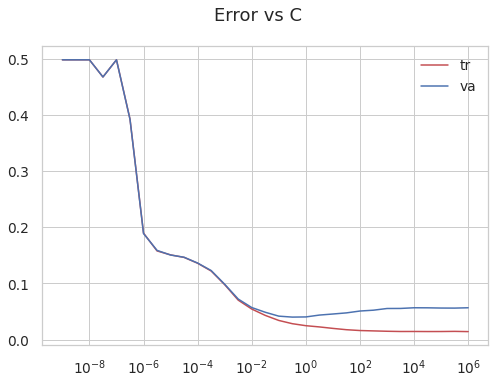

In [7]:
plt.plot(my_c_grid, err_tr, 'r-', label='tr')
plt.plot(my_c_grid, err_va, 'b-', label='va')
plt.xscale('log')
plt.legend(loc='upper right')
plt.suptitle('Error vs C')

In [8]:
my_best_c = my_c_grid[np.argmin(err_va)]
print('best C:', my_best_c)

best C: 0.31622776601683794


In [9]:
lr = sklearn.linear_model.LogisticRegression(max_iter=my_max_iter, solver=my_solver, C=my_best_c, n_jobs=-1)

lr.fit(x_tr_NF, y_tr_N)

yhat_tr_proba_N = lr.predict_proba(x_tr_NF)[:,1]
yhat_va_proba_M = lr.predict_proba(x_va_MF)[:,1]

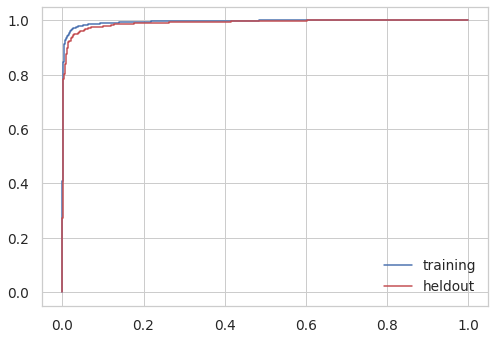

In [10]:
fpr_tr, tpr_tr, _ = sklearn.metrics.roc_curve(y_tr_N, yhat_tr_proba_N)
fpr_va, tpr_va, _ = sklearn.metrics.roc_curve(y_va_M, yhat_va_proba_M)

plt.plot(fpr_tr, tpr_tr, 'b-', label='training')
plt.plot(fpr_va, tpr_va, 'r-', label='heldout')
plt.legend(loc='lower right')

In [13]:
yhat_proba_te_M = lr.predict_proba(x_te_MF)
np.savetxt('yproba1_test.txt', yhat_proba_te_M, delimiter='\n')

In [16]:
np.loadtxt('yproba1_test.txt')

array([0.06559946, 0.93440054, 0.98707517, ..., 1.        , 0.00960287,
       0.99039713])

In [17]:
def coord_multiplier(coordinates):
    toReturn = np.copy(coordinates)
    for i in range(10*28, 19*28):
        toReturn[i] *= 10
    return toReturn

def amplify_center_values(x_NF, alpha):
    N, F = x_NF.shape
    
#     x_pos = np.arange(F) % 28
#     y_pos = np.floor(np.arange(F) / 28)
    
#     x_mult = multiplier(x_pos)
#     y_mult = multiplier(y_pos)
    
    x_NF_multiplied = np.copy(x_NF)
    
    for i in range(N):
        x_curr = x_NF[i,:]
#         x_curr = x_curr * alpha * x_mult * y_mult
        x_curr = coord_multiplier(x_curr)
        x_NF_multiplied[i,:] = x_curr
    
    return x_NF_multiplied
        

1.0

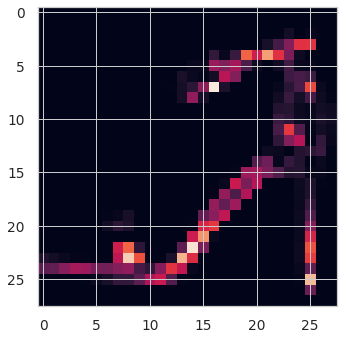

In [142]:
x_tr_NF_amp = factor_square_scale(x_tr_NF,1.5
                                 )
im=1
plt.imshow(x_tr_NF_amp[im,:].reshape((28,28)))
np.max(x_tr_NF_amp[im,:])

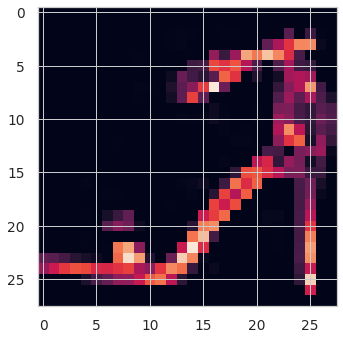

In [140]:
plt.imshow(x_tr_NF[im,:].reshape((28,28)))

In [33]:
multiplier_grid = np.arange(10) + 1 / 5.0

In [34]:
mult_err_tr = []
mult_err_va = []

for multiplier in multiplier_grid:
    transformed_data_NF = amplify_center_values(x_tr_NF, multiplier)
    
    lr = sklearn.linear_model.LogisticRegression(max_iter=my_max_iter, solver=my_solver, C=my_best_c, n_jobs=-1)
    
    scores = sklearn.model_selection.cross_validate(lr, transformed_data_NF, y_tr_N, 
                                                    cv=6, scoring=my_scoring, 
                                                    return_train_score=True, n_jobs=-1)
    mult_err_tr.append(np.mean(scores['train_score']))
    mult_err_va.append(np.mean(scores['test_score']))

Text(0.5, 0.98, 'Error vs Multiplier')

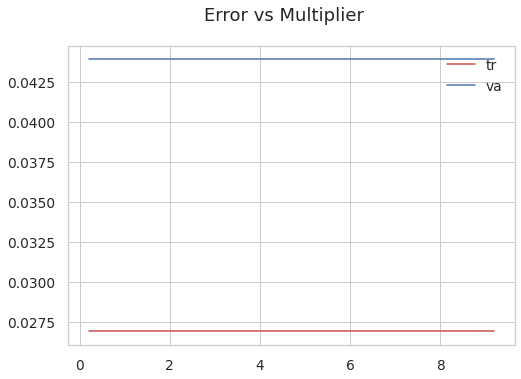

In [35]:
plt.plot(multiplier_grid, mult_err_tr, 'r-', label='tr')
plt.plot(multiplier_grid, mult_err_va, 'b-', label='va')
#plt.xscale('log')
plt.legend(loc='upper right')
plt.suptitle('Error vs Multiplier')

In [36]:
print(mult_err_tr)

[0.02691998968655651, 0.02691998968655651, 0.02691998968655651, 0.02691998968655651, 0.02691998968655651, 0.02691998968655651, 0.02691998968655651, 0.02691998968655651, 0.02691998968655651, 0.02691998968655651]


In [127]:
def factor_square_scale(x_NF, scale):
    x_scaled_NF = np.copy(x_NF) * scale
    x_squared_NF = np.square(x_scaled_NF)
    transformer = sklearn.preprocessing.MaxAbsScaler().fit(x_squared_NF)
    return transformer.transform(x_squared_NF)

In [43]:
def add_middle_avg_data(x_NF):
    array = []
    for i in range(N):
        x_curr = np.copy(x_NF[i,:])
        x_curr.resize((28,28))
        mean = np.mean(x_curr[8:20,8:20])
        array.append(mean)
    
    array = np.array(array)
    array = array[:,np.newaxis]
    return np.hstack((x_NF, array))
        

In [ ]:
my_thresh_grid = np.arange(2) + 1

thresh_err_tr = []
thresh_err_va = []
#('transform', sklearn.preprocessing.FunctionTransformer(func=factor_square_scale, kw_args={'scale':thresh})),
#('projection', sklearn.random_projection.GaussianRandomProjection(n_components=thresh))        
    m
for thresh in my_thresh_grid:
    pipeline = sklearn.pipeline.Pipeline([
        ('polynomial', sklearn.preprocessing.PolynomialFeatures(thresh)),
        ('regression', sklearn.linear_model.LogisticRegression(
            max_iter=my_max_iter, solver=my_solver, C=my_best_c, n_jobs=-1))
    ])
    
    pipeline.fit(x_tr_NF, y_tr_N)
    
    yhat_tr_N = pipeline.predict(x_tr_NF)
    yhat_va_M = pipeline.predict(x_va_MF)
    
    thresh_err_tr.append(sklearn.metrics.zero_one_loss(y_tr_N, yhat_tr_N))
    thresh_err_va.append(sklearn.metrics.zero_one_loss(y_va_M, yhat_va_M))
    

In [ ]:
plt.plot(my_thresh_grid, thresh_err_tr, 'r-', label='tr')
plt.plot(my_thresh_grid, thresh_err_va, 'b-', label='va')
#plt.xscale('log')
plt.legend(loc='upper right')
plt.suptitle('Error vs Threshold')

In [44]:
add_middle_avg_data(x_tr_NF)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.50240097],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06366875],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.13140542],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.40045361],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.34032889],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.14120139]])